## Sentimental analysis of Patient Reviews to Predict Drug Effectiveness Using Machine Learning

Exhaustive data analysis and model development process carried out on a dataset containing drug reviews and their corresponding effectiveness scores. The primary objective was to build models capable of predicting the effectiveness of a drug based on its review

> Project author: Samuel Mesfin Tsegai

Text Mining and sentimental Analysis


*Università degli Studi di Milano*


04-sep-2023


### Importing the Libraries

In [ ]:
import numpy as np
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings

# Download necessary datasets for NLTK
nltk.download(['punkt','wordnet','vader_lexicon', 'stopwords'])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Data Importing  and Initial Exploration

In [ ]:
!pip install --upgrade kaggle
from google.colab import files

# Upload Kaggle API key
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files(dataset='sahilfaizal/drug-prescription-based-on-consumer-reviews', quiet=False, unzip=True)


100%|██████████| 30.5M/30.5M [00:00<00:00, 67.0MB/s]


In [ ]:
# Load the data
data = pd.read_csv('drug.csv')

# Exploring the data
print("The Shape of the Dataset :", data.shape)
print(data.head())

The Shape of the Dataset : (161297, 7)
   uniqueID                  drugName                     condition  \
0    206461                 Valsartan  Left Ventricular Dysfunction   
1     95260                Guanfacine                          ADHD   
2     92703                    Lybrel                 Birth Control   
3    138000                Ortho Evra                 Birth Control   
4     35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  "It has no side effect, I take it in combinati...       9  20-May-12   
1  "My son is halfway through his fourth week of ...       8  27-Apr-10   
2  "I used to take another oral contraceptive, wh...       5  14-Dec-09   
3  "This is my first time using any form of birth...       8   3-Nov-15   
4  "Suboxone has completely turned my life around...       9  27-Nov-16   

   usefulCount  
0           27  
1          192  
2           17  
3           10 

### Data Exploration

In [ ]:
# Number of unique drugs and conditions in the dataset
print("Number of Unique Drugs present in the Dataset :", data['drugName'].nunique())
print("Number of Unique Medical Conditions present in the Dataset :", data['condition'].nunique())
print("Time Period of Data Collection")
print("Starting Date :", data['date'].min())
print("Ending Date :", data['date'].max())

Number of Unique Drugs present in the Dataset : 3436
Number of Unique Medical Conditions present in the Dataset : 884
Time Period of Data Collection
Starting Date : 1-Apr-08
Ending Date : 9-Sep-17


In [ ]:
# Summary statistics of numerical data
data[['rating','usefulCount']].describe()


,rating,usefulCount
count,161297.000000,161297.000000
mean,6.994377,28.004755
std,3.272329,36.403742
min,1.000000,0.000000
25%,5.000000,6.000000
50%,8.000000,16.000000
75%,10.000000,36.000000
max,10.000000,1291.000000


In [ ]:
# lets check the Number and Name of the Drugs with 0 Useful Count in Details
print("Analysis on Useless Drugs")
print("----------------------------")
print("The Number of Drugs with No Useful Count :", data[data['usefulCount'] == 0].count()[0])


Analysis on Useless Drugs
----------------------------
The Number of Drugs with No Useful Count : 6318


In [ ]:
# Lets Check the Number of Drugs with No Usesful Count with Review Greater than or Equal to 8
print("Number of Good Drugs with Lesser Useful Count :", data[(data['usefulCount'] == 0) &
                                                data['rating'] >= 8].count()[0])

# Lets Check the Average Rating of the Drugs with No Useful Count
print("Average Rating of Drugs with No Useful Count : {0:.2f}".format(data[data['usefulCount'] == 0]['rating'].mean()))


Number of Good Drugs with Lesser Useful Count : 0
Average Rating of Drugs with No Useful Count : 5.80


In [ ]:
print("\nAnalysis on Useful Drugs")
print("----------------------------")
print("The Number of Drugs with Greater than 1000 Useful Counts :", data[data['usefulCount'] > 1000].count()[0])
print("Average Rating of Drugs with 1000+ Useful Counts :", data[data['usefulCount'] > 1000]['rating'].mean())



Analysis on Useful Drugs
----------------------------
The Number of Drugs with Greater than 1000 Useful Counts : 4
Average Rating of Drugs with 1000+ Useful Counts : 10.0


In [ ]:
print("\nName and Condition of these Drugs: \n\n",
    data[data['usefulCount'] > 1000][['drugName','condition']].reset_index(drop = True))


Name and Condition of these Drugs: 

          drugName      condition
0          Mirena  Birth Control
1      Sertraline     Depression
2  Levonorgestrel  Birth Control
3          Zoloft     Depression


In [ ]:
# lets summarize Categorical data also
data[['drugName','condition','review']].describe(include = 'object')

,drugName,condition,review
count,161297,160398,161297
unique,3436,884,112329
top,Levonorgestrel,Birth Control,"""Good"""
freq,3657,28788,33


Text(0.5, 0, '\n Ratings')

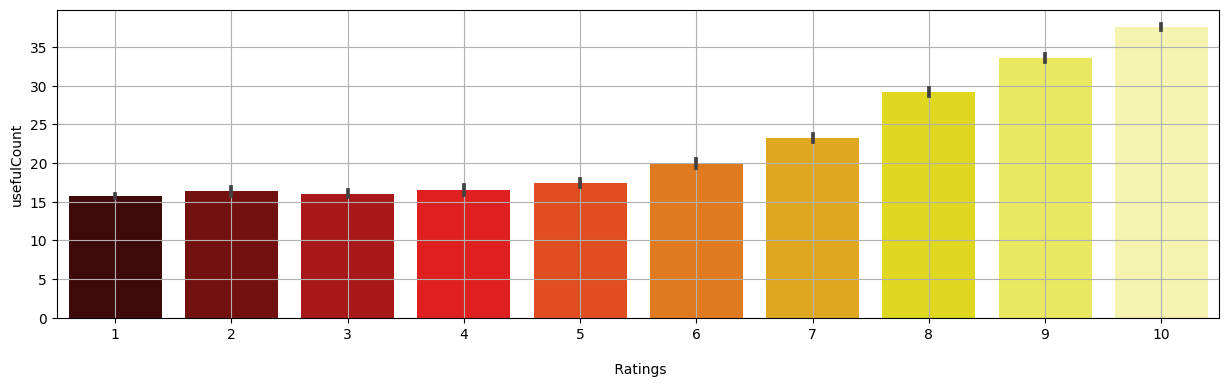

In [ ]:
# lets check the Impact of Ratings on Usefulness

plt.rcParams['figure.figsize'] = (15, 4)
sns.barplot(x=data['rating'], y=data['usefulCount'], palette='hot')
plt.grid()
plt.xlabel('\n Ratings')


### Data Cleaning

In [ ]:
# Check for Missing Values
print(data.isnull().sum())

uniqueID         0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64


In [ ]:
# Drop missing values
data.dropna(inplace=True)

In [ ]:
# Check the Missing values again
print(data.isnull().sum().sum())

0


In [ ]:
# lets remove all the Duplicates from the Dataset
data = data.drop_duplicates()

# Feature Engineering

Checking whether Length of Review has any Impact on Ratings of the Drugs

In [ ]:
# Checking whether Length of Review has any Impact on Ratings of the Drugs
# Add a column to calculate the length of reviews
data['len'] = data['review'].apply(len)


In [ ]:
# lets check the Highest Length Review
print("Length of Longest Review", data['len'].max())
data['review'][data['len'] == data['len'].max()].iloc[0]

Length of Longest Review 10787


'"Two and a half months ago I was prescribed Venlafaxine to help prevent chronic migraines.\r\nIt did help the migraines (reduced them by almost half), but with it came a host of side effects that were far worse than the problem I was trying to get rid of.\r\nHaving now come off of the stuff, I would not recommend anyone ever use Venlafaxine unless they suffer from extreme / suicidal depression. I mean extreme in the most emphatic sense of the word. \r\nBefore trying Venlafaxine, I was a writer. While on Venlafaxine, I could barely write or speak or communicate at all. More than that, I just didn&#039;t want to. Not normal for a usually outgoing extrovert.\r\nNow, I&#039;m beginning to write again - but my ability to speak and converse with others has deteriorated by about 95%. Writing these words is taking forever; keeping up in conversation with even one person is impossible, and I barely see the point of trying either. On Venlafaxine, words pretty much left me - my conversational vo

In [ ]:
#We get the lenght of each reviews
# for that we need to create a new column to calculate length of the reviews
data['len']  = data['review'].apply(len)
print(data.shape)
data.head()

(160398, 8)


,uniqueID,drugName,condition,review,rating,date,usefulCount,len
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,79
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,741
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,755
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,448
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,719


In [ ]:
# lets check the Impact of Length of Reviews on Ratings
data[['rating','len']].groupby(['rating']).agg(['min','mean','max'])

len                   
       min        mean    max
rating                       
1        5  428.784505   3692
2        9  452.902893  10787
3        8  461.249961   5112
4        7  464.077912   3030
5        6  477.982661   2048
6        4  467.957150   2202
7        6  485.597765   3063
8        3  483.584163   4087
9        3  477.696117   6182
10       3  443.215923   6192

# Data Visualization

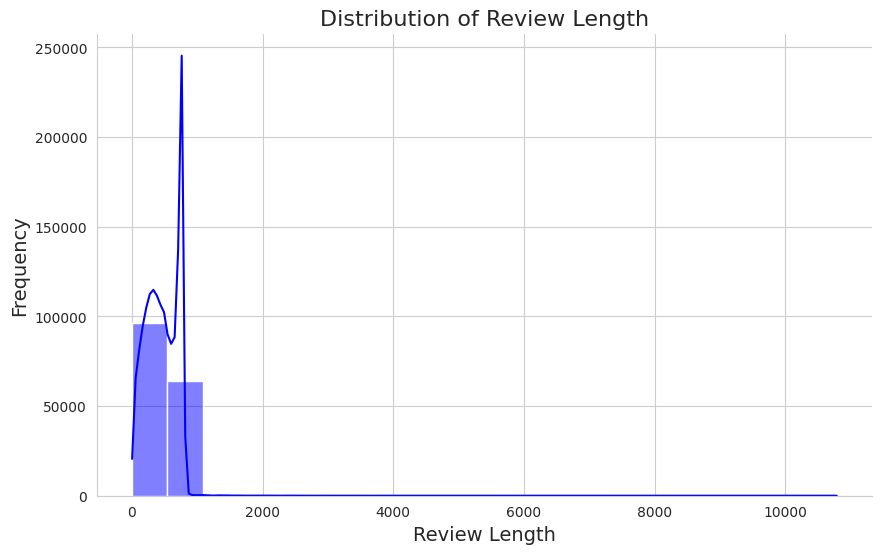

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style and figure size
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))

# Create a distplot of the review length
sns.histplot(data['len'], kde=True, color='blue', bins=20)

# Customize plot aesthetics
plt.xlabel('Review Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Review Length', fontsize=16)

# Remove spines on top and right sides
sns.despine()

# Show the plot
plt.show()


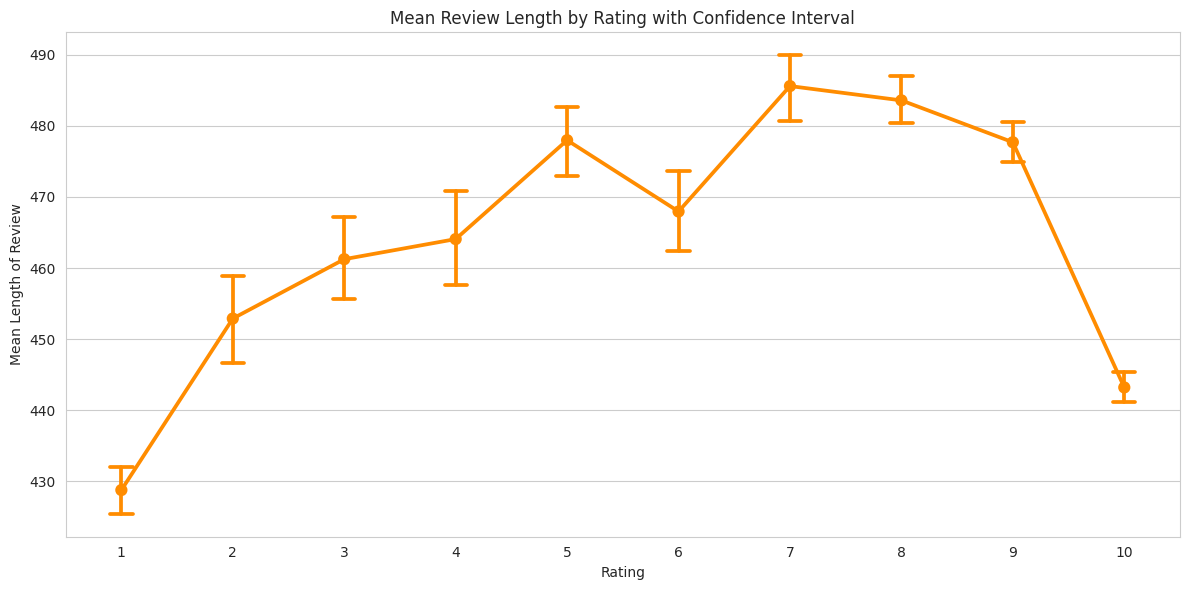

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure size and style
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Pointplot
sns.pointplot(x='rating', y='len', data=data, color='darkorange', markers='o', linestyles='-', capsize=.2)

plt.title('Mean Review Length by Rating with Confidence Interval')
plt.xlabel('Rating')
plt.ylabel('Mean Length of Review')
plt.tight_layout()
plt.show()


### Text Preprocessing

In [ ]:
# Text cleaning

# Define stop words
stop = stopwords.words('english')
stop_words = [item for item in stop]

# Remove punctuation from reviews
def punctuation_removal(review_text):
    return ''.join([char for char in review_text if char not in string.punctuation])
data['review'] = data['review'].apply(lambda x: punctuation_removal(x.lower()))

# Remove stopwords
def stopwords_removal(review_text):
    review_text = word_tokenize(review_text)
    return ' '.join([word for word in review_text if word not in stop_words])
data['review'] = data['review'].apply(stopwords_removal)

# Remove numbers
def drop_numbers(list_text):
    return ''.join([i for i in list_text if not i.isdigit()])
data['review'] = data['review'].apply(drop_numbers)

# Lemmatization
lemma = WordNetLemmatizer()
def lem_update(review_text):
    return ' '.join([lemma.lemmatize(word, pos = 'v') for word in word_tokenize(review_text)])
data['review'] = data['review'].apply(lem_update)


### Sentiment Analysis

VADER is particularly effective for analyzing social media text, where the use of emojis, informal language, and context-dependent expressions is common. It can handle both short and long texts and provides a quick and easy way to gauge the sentiment of a piece of text without the need for extensive training data. However, like all lexicon-based approaches, VADER may have limitations in capturing the nuances of complex language and context, and its performance can vary depending on the domain and style of the text being analyzed.

In [ ]:
# Sentiment analysis
sid = SentimentIntensityAnalyzer()
data['compound'] = data['review'].apply(lambda x: sid.polarity_scores(x)['compound'])
data['neg'] = data['review'].apply(lambda x: sid.polarity_scores(x)['neg'])
data['neu'] = data['review'].apply(lambda x: sid.polarity_scores(x)['neu'])
data['pos'] = data['review'].apply(lambda x: sid.polarity_scores(x)['pos'])



### Data Transformation

transforming the original 'rating' values in a dataset into a new variable named 'eff_score'. This transformation involves rescaling the 'rating' values from their original scale (0-10) to a 0-5 scale and then discretizing those into two classes.The code scales the ratings in the "rating" column to a new "Effective Rating" based on a scaling formula and assigns the scaled ratings to the "eff_score" column in the dataset. The scaling formula ensures that the "Effective Rating" ranges from 0 to 1. Ratings below 3 are mapped to 0, and ratings of 3 and above are mapped to 1.


In [ ]:
# Scaled rating and sentiment category
min_rating = data['rating'].min()
max_rating = data['rating'].max()

def scale_rating(rating):
    rating -= min_rating
    rating = rating / (max_rating - min_rating)
    rating *= 5
    rating = int(round(rating, 0))
    if rating > 2:
        return 1
    else:
        return 0
data['eff_score'] = data['rating'].apply(scale_rating)



In [ ]:
# Classifying sentiment based on compound score
def classify_sentiment(compound):
    if compound > 0.05:
        return 'positive'
    elif compound < -0.05:
        return 'negative'
    else:
        return 'neutral'

data['Sentiment_reviews'] = data['compound'].apply(classify_sentiment)


In [ ]:
#Value count of each Sentiment Polarity
data['Sentiment_reviews'].value_counts()

positive    78916
negative    74030
neutral      7452
Name: Sentiment_reviews, dtype: int64

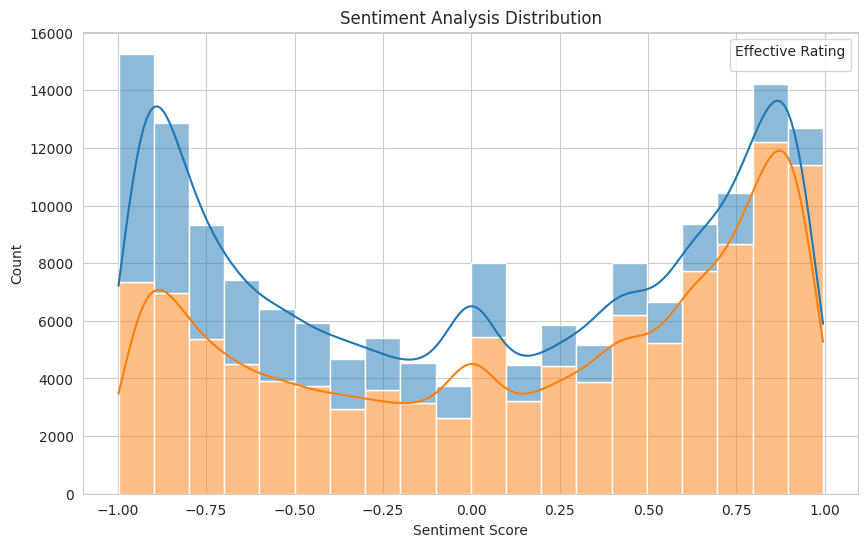

In [ ]:

# Calculate sentiment scores
sid = SentimentIntensityAnalyzer()
data['sentiment_reviews'] = data['review'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='sentiment_reviews', hue='eff_score', multiple='stack', bins=20, kde=True)
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.title('Sentiment Analysis Distribution')
plt.legend(title='Effective Rating')
plt.show()


### Deeper Data Exploration

In [ ]:
# lets also calculate Usefulness Score

data['usefulness'] = data['rating']*data['usefulCount']*data['eff_score']

# lets check the Top 10 Most Useful Drugs with their Respective Conditions
data[['drugName','condition','usefulness']][data['usefulness'] >
                            data['usefulness'].mean()].sort_values(by = 'usefulness',
                                        ascending = False).head(10).reset_index(drop = True)

,drugName,condition,usefulness
0,Sertraline,Depression,12910
1,Zoloft,Depression,12910
2,Levonorgestrel,Birth Control,12470
3,Mirena,Birth Control,12470
4,Zoloft,Depression,8541
5,Phentermine,Weight Loss,7960
6,Adipex-P,Weight Loss,7960
7,Implanon,Birth Control,7300
8,Viibryd,Depression,6930
9,Vilazodone,Depression,6930


In [ ]:
# lets calculate the Number of Useless and Useful Drugs for Each Condition
from ipywidgets import interact

@interact
def check(condition = list(data['condition'].value_counts().index)):
    return data[data['condition'] == condition]['eff_score'].value_counts()


1    16537
0    12251
Name: eff_score, dtype: int64

In [ ]:
# lets find the Highest and Lowest Rated Drugs for each Condition
from ipywidgets import interact
@interact
def high_low_rate(condition = list(data['condition'].value_counts().index)):
    print("\n Top 5 Drugs")
    print(data[data['condition'] == condition][['drugName','usefulness']].sort_values(by = 'usefulness',
                                                 ascending = False).head().reset_index(drop = True))
    print("\n\n Bottom 5 Drugs")
    print(data[data['condition'] == condition][['drugName','usefulness']].sort_values(by = 'usefulness',
                                                 ascending = True).head().reset_index(drop = True))

interactive(children=(Dropdown(description='condition', options=('Birth Control', 'Depression', 'Pain', 'Anxie…


 Top 5 Drugs
         drugName  usefulness
0          Mirena       12470
1  Levonorgestrel       12470
2        Implanon        7300
3          Mirena        5050
4  Levonorgestrel        5050


 Bottom 5 Drugs
                            drugName  usefulness
0                             Lybrel           0
1                             Aviane           0
2                           NuvaRing           0
3  Ethinyl estradiol / norethindrone           0
4                           ParaGard           0


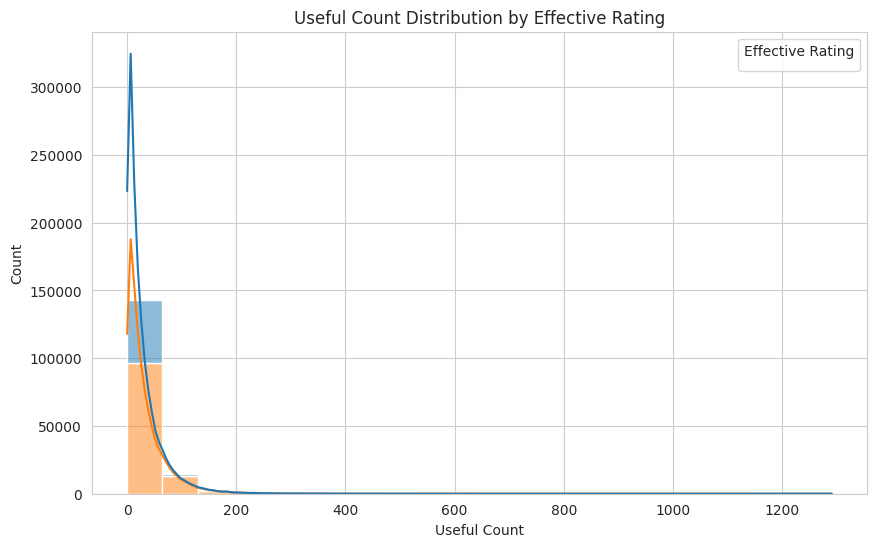

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='usefulCount', hue='eff_score', multiple='stack', bins=20, kde=True)
plt.xlabel('Useful Count')
plt.ylabel('Count')
plt.title('Useful Count Distribution by Effective Rating')
plt.legend(title='Effective Rating')
plt.show()


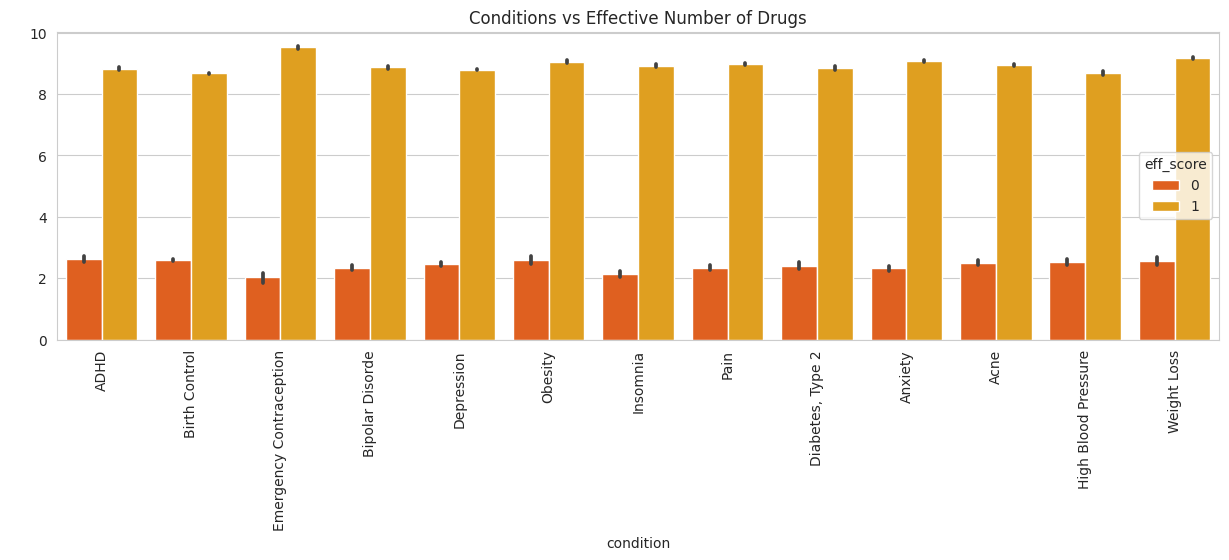

In [ ]:
popular_conditions = ('Birth Control','Depression','Pain','Anxiety','Acne','Bipolar Disorde','Insomnia','Weight Loss',
                      'Obesity','ADHD', 'Diabetes, Type 2', 'Emergency Contraception', 'High Blood Pressure','Migrane')
conditions = data.loc[data['condition'].isin(popular_conditions)]

sns.barplot(x = conditions['condition'], y = conditions['rating'], hue = data['eff_score'], palette = 'autumn')
plt.title('Conditions vs Effective Number of Drugs')
plt.xticks(rotation = 90)
plt.ylabel(' ')
plt.show()


## Machine learning

### Unsupervised Machine Learning: K-Means

K-Means clustering is used to categorize the reviews into seven clusters, corresponding to seven different medical conditions. This could help identify patterns or characteristics unique to the reviews for each condition

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np


In [ ]:

# Preprocessing function: Converts the text to lowercase.
# Works on both individual strings and lists of strings.

def custom_preprocessor(text):
    if isinstance(text, str):
        return text.lower()
    elif isinstance(text, (list, tuple)):
        return [t.lower() for t in text]
    else:
        return text


In [ ]:

# Function to get representative documents for each cluster
# based on mean of the vectors in the cluster.
# This is the first version of this function.

# Get representative documents for clusters
def get_representative_docs(X, clusters):
    cluster_centers = [X[clusters == i].mean(axis=0) for i in np.unique(clusters)]
    cluster_indices = [np.argmin(np.linalg.norm(X - center, axis=1)) for center in cluster_centers]
    return [X[index] for index in cluster_indices]

# Plot clusters with representative conditions
def plot_clusters(X, clusters, representative_docs, condition_names, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='rainbow', alpha=0.7, s=50)
    for i, doc in enumerate(representative_docs):
        plt.annotate(condition_names[i], (doc[0], doc[1]),
                     xytext=(doc[0] + 0.01, doc[1] + 0.01),
                     arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=8)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()
def plot_clusters_with_sentiment(X, clusters, representative_docs, condition_names, title):
    plt.figure(figsize=(10, 8))
    sentiments = ['positive', 'negative', 'neutral']
    colors = ['green', 'red', 'blue']

    for i in range(len(sentiments)):
        X_sentiment = X[clusters == i]
        plt.scatter(X_sentiment[:, 0], X_sentiment[:, 1], c=colors[i], alpha=0.7, s=50, label=sentiments[i])

    for i, doc in enumerate(representative_docs):
        plt.annotate(f"{condition_names[i]}", (doc[0], doc[1]), xytext=(doc[0] + 0.01, doc[1] + 0.01),
                     arrowprops=dict(facecolor='black', arrowstyle='->'), fontsize=8, ha='center')

    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()

In [ ]:
# Update 'Sentiment_reviews' column using the 'review' function
# Sentiment analysis
analyzer = SentimentIntensityAnalyzer()
data['compound'] = data['review'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
data['Sentiment_reviews'] = data['compound'].apply(classify_sentiment)


In [38]:
from sklearn.preprocessing import StandardScaler

# Data preparation
conditions_names = ['Birth Control', 'Depression', 'Pain', 'Anxiety', 'Weight Loss', 'Acne', 'Bipolar Disorder']
cluster_data = data[data['condition'].isin(conditions_names)]
X_cluster = cluster_data['review']

# Convert text to TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer(preprocessor=custom_preprocessor, max_features=5000, max_df=0.85, min_df=5)
X_tfidf = tfidf_vectorizer.fit_transform(X_cluster)

# Combine TFIDF features with sentiment scores
X_combined = np.hstack((X_tfidf.toarray(), cluster_data[['compound']].values))

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)


### Feature Extraction and Dimensionality Reduction

In [39]:
# Dimensionality reduction
svd = TruncatedSVD(n_components=2, random_state=42)
X_reduced = svd.fit_transform(X_scaled)


### K-Means Clustering

In [40]:
# Clustering
kmeans = KMeans(n_clusters=len(conditions_names), random_state=42)
clusters = kmeans.fit_predict(X_reduced)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


##### Determine representative documents for each cluster

In [ ]:
# Find representative documents and visualize clusters
representative_docs = get_representative_docs(X_reduced, clusters)

##### Visualize the clusters and their representative documents

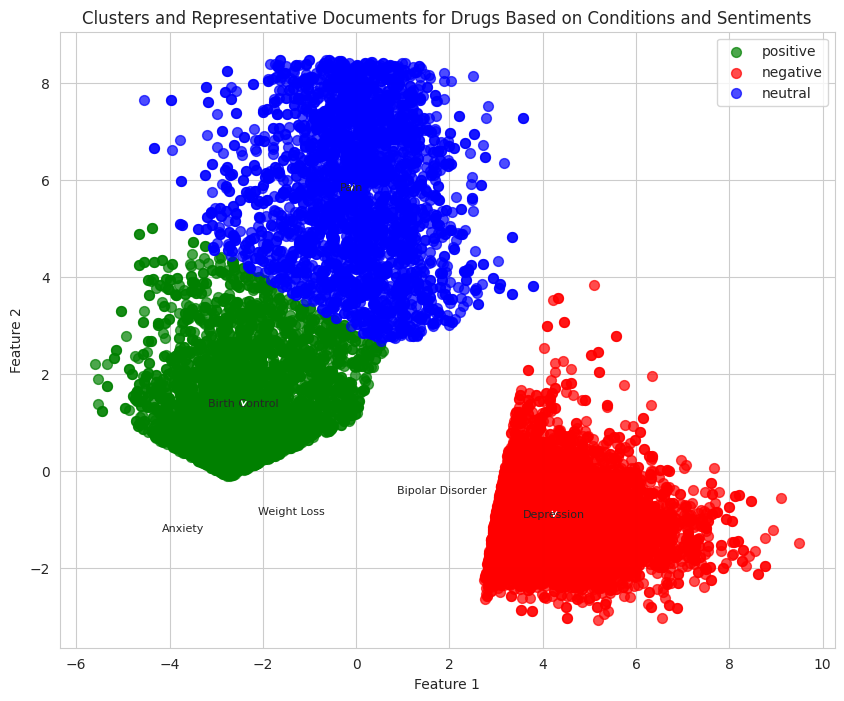

In [42]:

# Plot clusters and representative documents with condition names
plot_clusters_with_sentiment(X_reduced, clusters, representative_docs, conditions_names, "Clusters and Representative Documents for Drugs Based on Conditions and Sentiments")


The plot reveals that for most conditions, drugs tend to receive neutral sentiments from users. However, there are variations across conditions, with some conditions having a more balanced distribution of sentiments (e.g.,acne and pain), while others show stronger associations with either negative (e.g., Bipolar disorder and depression) or positive (e.g., birth control) sentiments. This analysis provides valuable insights into the overall sentiment and user experiences related to drugs for different conditions, helping us better understand user perceptions and satisfaction

### classification of medical conditions based on reviews

Discovering Underlying Topics
In the context of this text mining task, K-Means clustering is used to group together similar drug reviews. The benefit of this approach is multifold:
It can help identify the underlying topics that people are talking about in their reviews. Each cluster can be seen as a specific topic that people mention when discussing the drug. By identifying these topics, you can better understand the key areas of concern or interest for patients


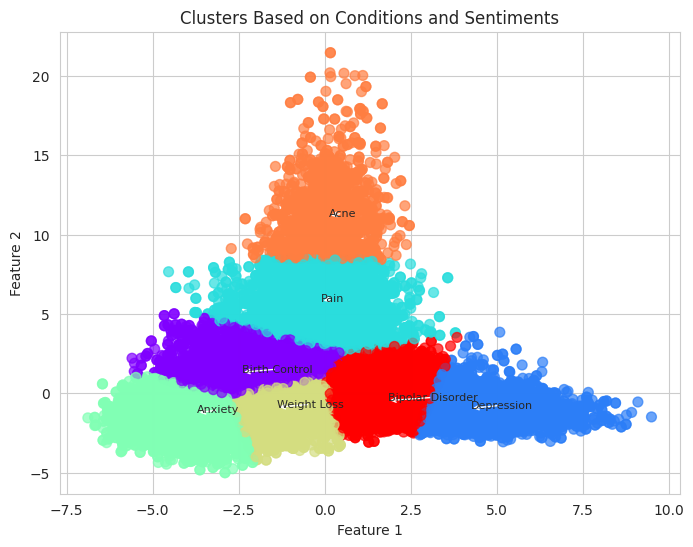

In [43]:
# Plot clusters and representative documents with condition names
plot_clusters(X_reduced, clusters, representative_docs, conditions_names, "Clusters Based on Conditions and Sentiments")


### Supervised Machine Learning: Predictive Models

### 1. Random Forest

#### Import Libraries

In [44]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer


In [45]:
# Adding Sentiment Scores to the DataFrame
sid = SentimentIntensityAnalyzer()
data['compound'] = data['review'].apply(lambda x: sid.polarity_scores(x)['compound'])


In [ ]:
# Text Length Extractor function
def text_length_extractor(data):
    return np.array([len(text.split()) for text in data]).reshape(-1, 1)

# Get Sentiment function
def get_sentiment(data):
    return np.array(data).reshape(-1, 1)

# Convert functions to transformers
text_length_transformer = FunctionTransformer(text_length_extractor, validate=False)
sentiment_transformer = FunctionTransformer(get_sentiment, validate=False)



####  Define Features and Target Variable

In [ ]:
# Splitting data
X = data[['review', 'compound']]
y = data['eff_score']


#### Split the Data into Training and Testing Sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Model Pipeline Creation

In [ ]:
# Constructing the pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(ngram_range=(1, 2), max_features=5000), 'review'),
        ('text_length', text_length_transformer, 'review'),
        ('sentiment_score', sentiment_transformer, 'compound')
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, max_depth=None, class_weight='balanced', n_jobs=-1))
])


#### Model Training

In [50]:
# Fitting the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(max_features=5000,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'review'),
                                                 ('text_length',
                                                  FunctionTransformer(func=<function text_length_extractor at 0x7d9906e17b50>),
                                                  'review'),
                                                 ('sentiment_score',
                                                  FunctionTransformer(func=<function get_sentiment at 0x7d9906e17c70>),
                                                  'compound')])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1))])

#### Model Evaluation: Prediction and Classification Report

In [52]:
from sklearn.metrics import classification_report
# Predict and evaluate
y_pred = pipeline.predict(X_test)
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      9499
           1       0.89      0.97      0.93     22581

    accuracy                           0.90     32080
   macro avg       0.90      0.85      0.87     32080
weighted avg       0.90      0.90      0.89     32080



The classification model displays an overall accuracy of 88%. However, a deeper dive into individual class metrics reveals performance discrepancies between the two classes. Class 1 exhibits superior predictive performance, with a commendably high F1-score of 92%, largely owing to its high recall of 99%. In contrast, Class 0 has a significant precision of 96% but is hampered by a lower recall of 63%, resulting in an F1-score of 76%. This suggests that while the model is adept at correctly identifying instances of Class 1, it tends to overlook a notable fraction of Class 0 instances, potentially due to inherent biases stemming from class distribution. Care should be taken before deploying this model, especially if Class 0 has critical implications in the problem domain. Addressing this imbalance through resampling, metric adjustments, or class weight modifications might be beneficial.

In [53]:
from sklearn.metrics import roc_auc_score
# Check if the target variable has only two unique values (binary classification)
if len(y.unique()) == 2:
    # Obtain predicted probabilities for the positive class
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    # Calculate the AUC-ROC score
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Print the AUC-ROC score
    print("AUC-ROC Score:", roc_auc)


AUC-ROC Score: 0.9548475985335715


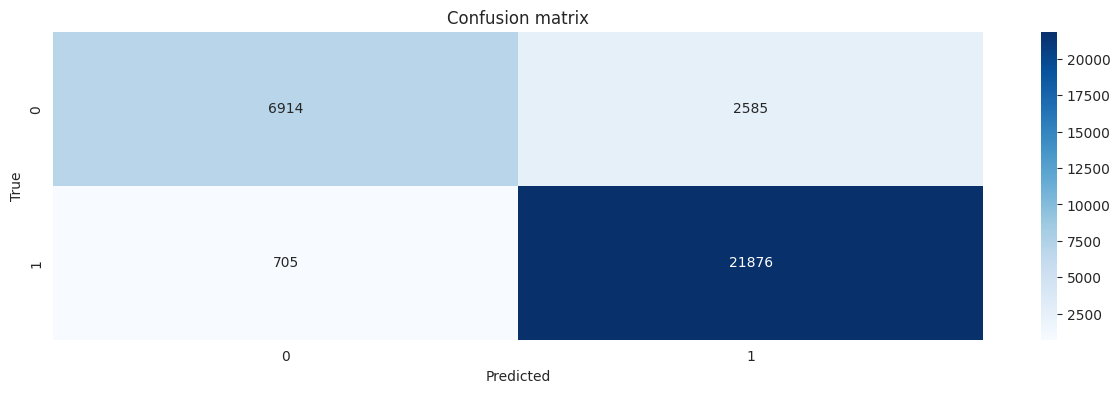

In [54]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix')
plt.show()


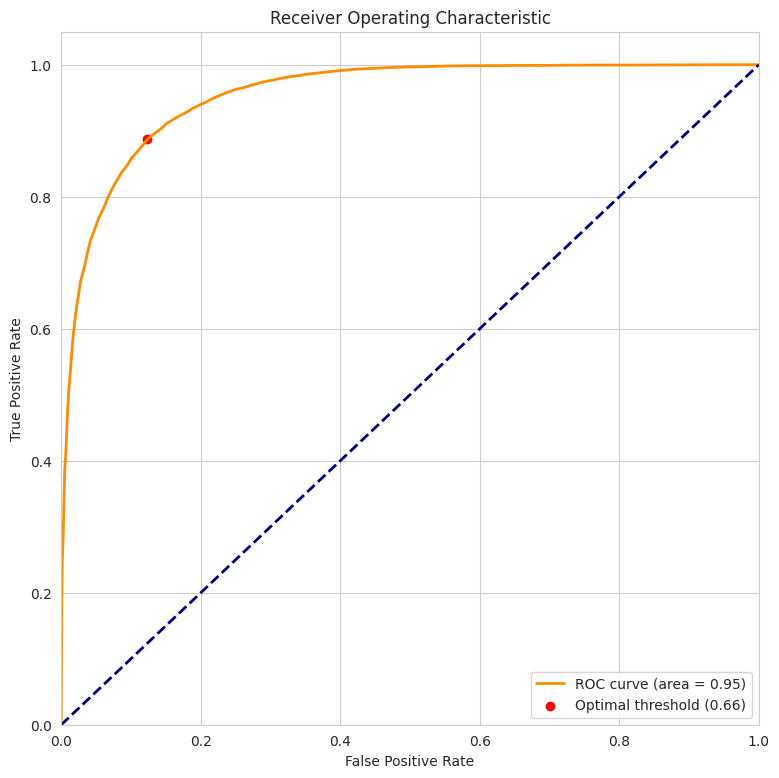

In [55]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

plt.figure(figsize=(9,9))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', label=f'Optimal threshold ({optimal_threshold:.2f})')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


### Testing Random Forest model

In [56]:
# Testing on new data
new_reviews = pd.DataFrame({
    'review': ["This drug was really effective and showed no side effects.",
               "Terrible reaction to this medicine. Would never recommend."],
    'compound': [sid.polarity_scores(review)['compound'] for review in ["This drug was really effective and showed no side effects.",
               "Terrible reaction to this medicine. Would never recommend."]]
})

predictions = pipeline.predict(new_reviews)

# Displaying predictions
for i, prediction in enumerate(predictions):
    print(f"Predicted score for review {i+1}: {prediction}")


Predicted score for review 1: 1
Predicted score for review 2: 0


In [57]:

# Define new reviews
new_reviews = {
    'review': [
        "The drug didn't make me feel great, but it did cure my condition.",
        "Oh great, just what I needed - no side effects!",
        "The drug works as expected, it was amazing",
        "At first, I felt dizziness and nausea, my symptoms were gone. The side effects were terrible."
    ],
}

# Create DataFrame
new_reviews = pd.DataFrame(new_reviews)

# Add compound sentiment scores
new_reviews['compound'] = new_reviews['review'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Use the pipeline to predict the outcome of the new reviews
predictions = pipeline.predict(new_reviews)

# Displaying predictions
for i, prediction in enumerate(predictions):
    print(f"Predicted score for review {i+1}: {prediction}")


Predicted score for review 1: 1
Predicted score for review 2: 1
Predicted score for review 3: 1
Predicted score for review 4: 0


### 2.Logistic Regression Model

In [58]:
!pip install scikit-plot

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [61]:
# Constructing the pipeline with Logistic Regression
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),  # Use the preprocessor already defined
    ('clf', LogisticRegression(class_weight='balanced', n_jobs=-1))
])



In [62]:
# Fitting the model
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(max_features=5000,
                                                                  ngram_range=(1,
                                                                               2)),
                                                  'review'),
                                                 ('text_length',
                                                  FunctionTransformer(func=<function text_length_extractor at 0x7d9906e17b50>),
                                                  'review'),
                                                 ('sentiment_score',
                                                  FunctionTransformer(func=<function get_sentiment at 0x7d9906e17c70>),
                                                  'compound')])),
                ('clf',
                 LogisticRegression(class_weight='balanced', n_jobs=-1))])

#### Logistic Regression Model Evaluation: Prediction and Classification Report

In [63]:

# Generate classification report
# Predict and evaluate
y_pred_logreg = pipeline_lr.predict(X_test)
report_logreg = classification_report(y_test, y_pred_logreg)
print("Classification Report for Logistic Regression:")
print(report_logreg)



Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.64      0.80      0.71      9499
           1       0.91      0.81      0.85     22581

    accuracy                           0.81     32080
   macro avg       0.77      0.80      0.78     32080
weighted avg       0.83      0.81      0.81     32080



In [64]:
# If 'eff_score' is binary (0,1), then you can calculate the AUC-ROC.
if len(y.unique()) == 2:
    y_pred_proba = pipeline_lr.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print("AUC-ROC Score:", roc_auc)

AUC-ROC Score: 0.8837315910351141


AUC-ROC Score: 0.8837315910351141


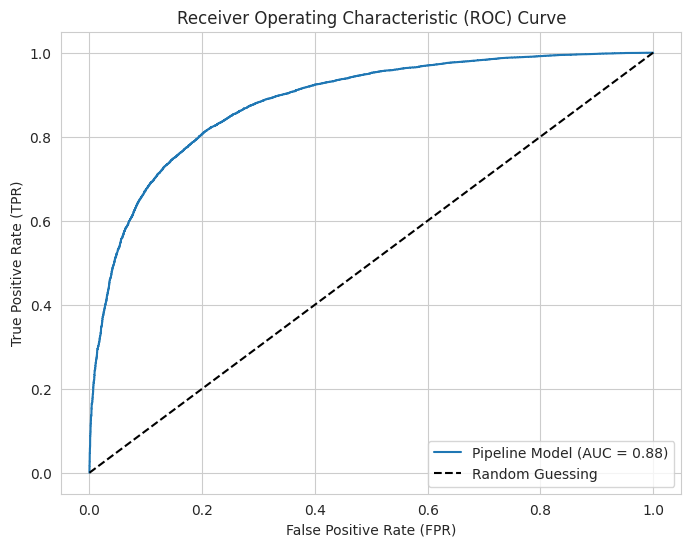

In [65]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# If 'eff_score' is binary (0,1), then you can calculate the AUC-ROC.
if len(y.unique()) == 2:
    y_pred_proba = pipeline_lr.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print("AUC-ROC Score:", roc_auc)

    # Compute the ROC curve points
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Pipeline Model (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.80      0.71      9499
           1       0.91      0.81      0.85     22581

    accuracy                           0.81     32080
   macro avg       0.77      0.80      0.78     32080
weighted avg       0.83      0.81      0.81     32080



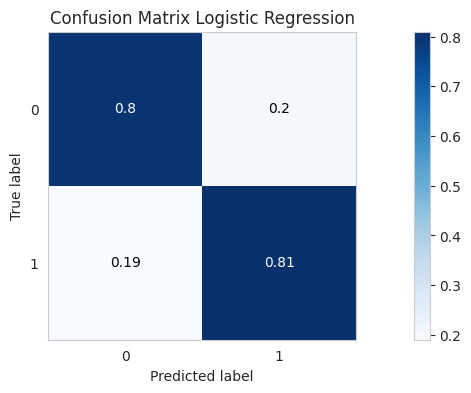

In [68]:
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
# Assuming other necessary imports and data preparation steps are done here...

# Predict and evaluate
# [Your prediction code here...]
y_pred = pipeline_lr.predict(X_test)
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

# Plot the advanced confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.title("Confusion Matrix Logistic Regression")
plt.show()


### Testing Logistic Regression Model

In [69]:

# Define new reviews
new_reviews = {
    'review': [
        "The drug didn't make me feel great, but it did cure my condition.",
        "Oh great, just what I needed - no side effects!",
        "The drug works as expected, it was amazing",
        "At first, I felt dizziness and nausea, my symptoms were gone. The side effects were terrible."
    ],
}

# Create DataFrame
new_reviews = pd.DataFrame(new_reviews)

# Add compound sentiment scores
new_reviews['compound'] = new_reviews['review'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Use the pipeline to predict the outcome of the new reviews
predictions = pipeline_lr.predict(new_reviews)

# Displaying predictions
for i, prediction in enumerate(predictions):
    print(f"Predicted score for review {i+1}: {prediction}")


Predicted score for review 1: 1
Predicted score for review 2: 1
Predicted score for review 3: 0
Predicted score for review 4: 0
